In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency, kruskal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from google.colab import drive

In [2]:
# Mount your Google Drive
try:
  drive.mount('/content/gdrive')
except Exception as e:
  print(f"Mounting failed! Error: {e}")
  exit()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [51]:
# Specify the path to your data on Google Drive
data_path = '/content/gdrive/My Drive/Week-3/MachineLearningRating_v3.txt'
# Load the dataset
data = pd.read_csv(data_path, sep="|", low_memory=False)
print(data.head())

   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...                    ExcessSelected CoverCategory  \
0  Current account  ...             Mobility - 

In [52]:
print(data.columns)


Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims'],
      dtype='object')


Model Evaluation Results:
                            MSE         MAE        R2
Linear Regression  5.374605e+06  132.417393  0.007093
Decision Tree      6.701509e+06  133.584245 -0.238040
Random Forest      6.695523e+06  134.637780 -0.236934
XGBoost            5.767719e+06  139.465337 -0.065531


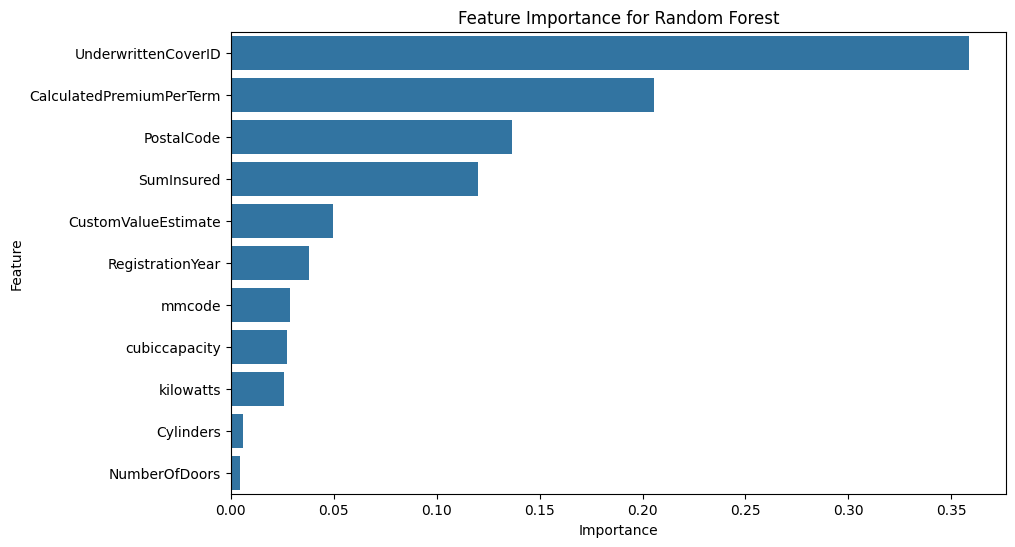

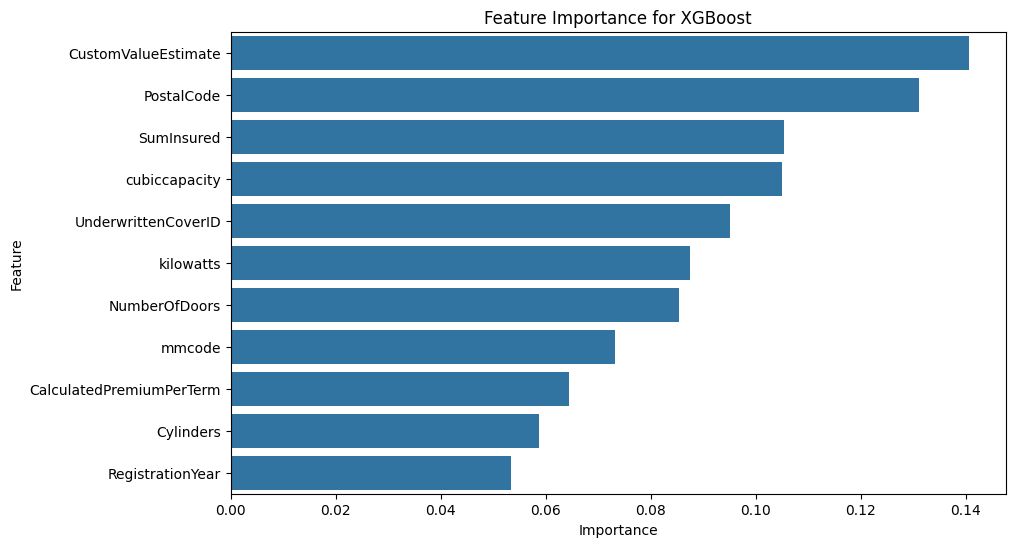

In [53]:
# Drop non-numeric columns
data_numeric = data.select_dtypes(include=[np.number]).drop(columns=['NumberOfVehiclesInFleet'])

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
data_numeric_imputed = pd.DataFrame(imputer.fit_transform(data_numeric), columns=data_numeric.columns)

# Train-Test Split
X = data_numeric_imputed.drop(['TotalPremium', 'TotalClaims', 'PolicyID'], axis=1)  # Features
y = data_numeric_imputed['TotalClaims']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Building
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),  # Reduced estimators
    'XGBoost': XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1)  # Reduced estimators
}

# Training and Evaluating Models
evaluation_results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    evaluation_results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Display evaluation results
results_df = pd.DataFrame(evaluation_results).T
print("Model Evaluation Results:")
print(results_df)

# Feature Importance Analysis
for model_name, model in models.items():
    if model_name in ['Random Forest', 'XGBoost']:
        feature_importances = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importance for {model_name}')
        plt.show()